<div style="display:flex">
    <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="Logo 1">
</div>

# Traffic Signs Detection

## Table of Contents
1. **[Part 1: Data preparation](#part1)**
   - 1.1. Loading and Exploring Data
   - 1.2. Image and Label Structure 
   - 1.3. Class Distribution Analysis

2. **[Part 2: Few-Shot Training](#part2)**
   - 2.1 Few-Shot Dataset Creation
   - 2.2 Model 1: Binary Cross Entropy Loss
   - 2.3 Model 2: Focal Loss

3. **[Full Dataset Training??](#part3)**
   - 3.1 ...

   


### Install and Import libraries

In [1]:
#!pip install ultralytics

In [1]:
# Importing Libraries
import os
import cv2
import glob
import shutil
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style='darkgrid')
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Video

from tqdm.notebook import trange, tqdm

import yaml
from ultralytics import YOLO

import warnings
warnings.filterwarnings('ignore')

# Setting the random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Part 1: Data Preparation <a id="part1"></a>

To investigate the dataset, we will first check that there are no mismatches between images and labels, then understand how the labelling system works and how its paired to the images, and visualize some examples.  Additionally, we can check the classes distribution

### Utilities functions

In [2]:
# Function to display an image with its bounding boxes
def display_image_with_boxes(image_path, label_file, include_label=True):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the label file
    with open(label_file, 'r') as file:
        labels = file.readlines()

    # Draw bounding boxes on the image
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Convert YOLO format to pixel coordinates
        img_height, img_width, _ = image.shape
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put class ID text
        if include_label:
            cv2.putText(image, class_names[str(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show() 

In [3]:
# Function to get the label file path from the image path
def get_label_file(image_path):
    # Replace 'images' with 'labels' in the path
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    return label_path

In [4]:
# Set the directory paths
path= os.getcwd()
Image_dir = os.path.join(path, 'data', 'train', 'images')
image_files = os.listdir(Image_dir)

Understand how labels are structured and paired with images

Labels for FisheyeCamera_1_00076_png.rf.c1649fd1ef9e95ffa77a31dcffb825ed.jpg:
0 0.3641826923076923 0.41346153846153844 0.015625 0.009615384615384616
7 0.36778846153846156 0.5456730769230769 0.006009615384615385 0.008413461538461538
1 0.4495192307692308 0.5024038461538461 0.006009615384615385 0.003605769230769231


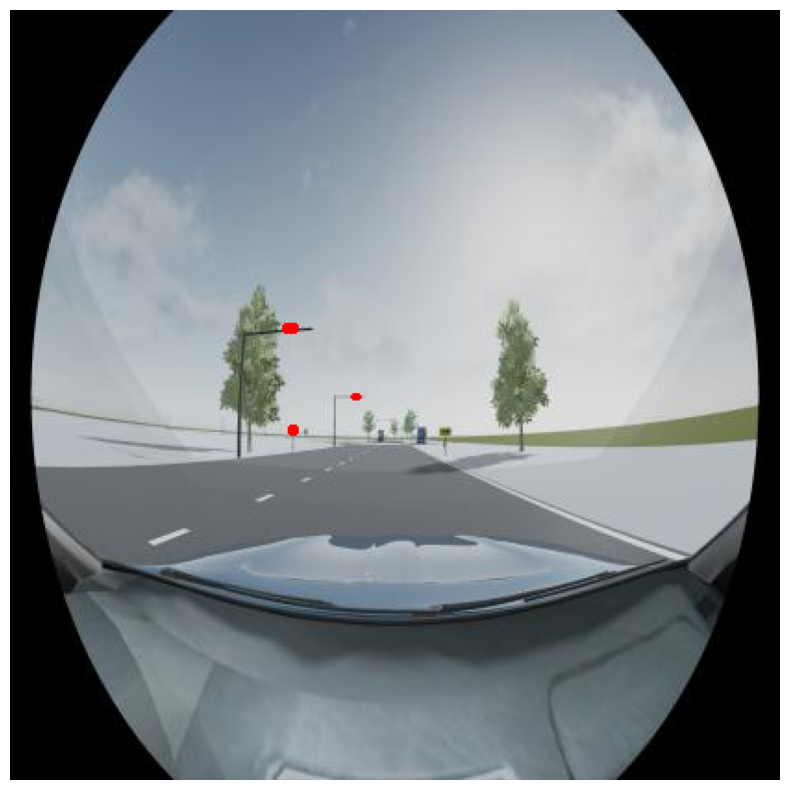

In [5]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")
# Display a random image with its bounding boxes

display_image_with_boxes(random_image_path, label_file, include_label=False)


As we can observe, labels are not in natural languange, but rather encoded in an intengers list. Let's further investigate on that, and create a dictionary the class numbers (6) to natural language labels (speed limit 20), using the information on the kaggle dataset

In [6]:
# get a set of all image labels (only the number of the class)
labels = set()
for image in image_files:
    label_file = get_label_file(os.path.join(Image_dir, image))
    if os.path.exists(label_file):
        with open(label_file, 'r') as file:
            for line in file:
                class_id = line.strip().split()[0]
                labels.add(class_id)

# Convert the set to a sorted list
labels = sorted(labels)
# Display the unique labels
print(f"Unique labels found in the dataset: {labels}")


Unique labels found in the dataset: ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
# create a dictionary to map class IDs to class names
class_names = {
    '0': 'Green Light',
    '1': 'Red Light',
    '2': 'Speed Limit 10',  
    '3': 'Speed Limit 100',
    '4': 'Speed Limit 110',
    '5': 'Speed Limit 120',
    '6': 'Speed Limit 20',
    '7': 'Speed Limit 30',
    '8': 'Speed Limit 40',
    '9': 'Speed Limit 50',
    '10': 'Speed Limit 60',
    '11': 'Speed Limit 70',
    '12': 'Speed Limit 80',
    '13': 'Speed Limit 90',
    '14': 'Stop'}

Let's now verify that these label names are correct (we can re run the following code chunk multiple times to assert this)

Labels for 00002_00017_00008_png.rf.958d92ad47742185bf2850483fb42da9.jpg:
9 0.5120192307692307 0.4795673076923077 0.6177884615384616 0.6430288461538461


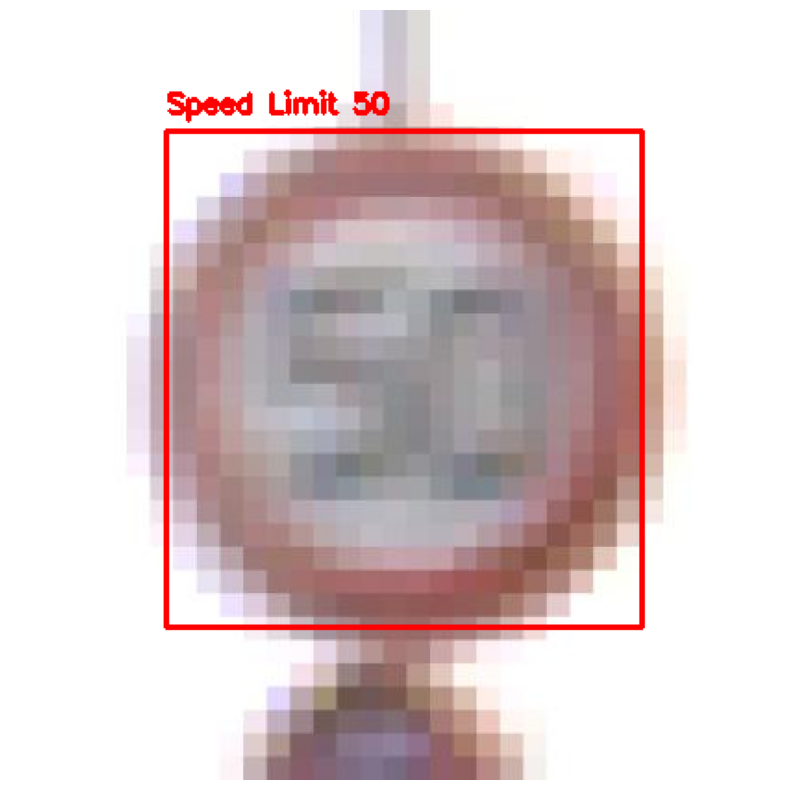

In [8]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")


# Display a random image with its bounding boxes
display_image_with_boxes(random_image_path, label_file)

Look for mismatches

In [9]:
# Count total amount of train, val and test images (+ labels)
train_images = os.listdir(Image_dir)
train_labels = os.listdir(os.path.join(path, 'data', 'train', 'labels'))
print(f'Total number of training images: {len(train_images)}')
print(f'Total number of training labels: {len(train_labels)}\n')

val_images = os.listdir(os.path.join(path, 'data', 'valid', 'images'))
val_labels = os.listdir(os.path.join(path, 'data', 'valid', 'labels'))
print(f'Total number of validation images: {len(val_images)}')    
print(f'Total number of validation labels: {len(val_labels)}\n')   

test_images = os.listdir(os.path.join(path, 'data', 'test', 'images'))
test_labels = os.listdir(os.path.join(path, 'data', 'test', 'labels'))

print(f'Total number of test images: {len(test_images)}')
print(f'Total number of test labels: {len(test_labels)}')

Total number of training images: 3530
Total number of training labels: 3530

Total number of validation images: 801
Total number of validation labels: 801

Total number of test images: 638
Total number of test labels: 638


Check Image shape

In [10]:
# Get the size of a random image
random_image_path = os.path.join(Image_dir, random.choice(image_files))

# Load the image
image = cv2.imread(random_image_path)

# Get the size of the image
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


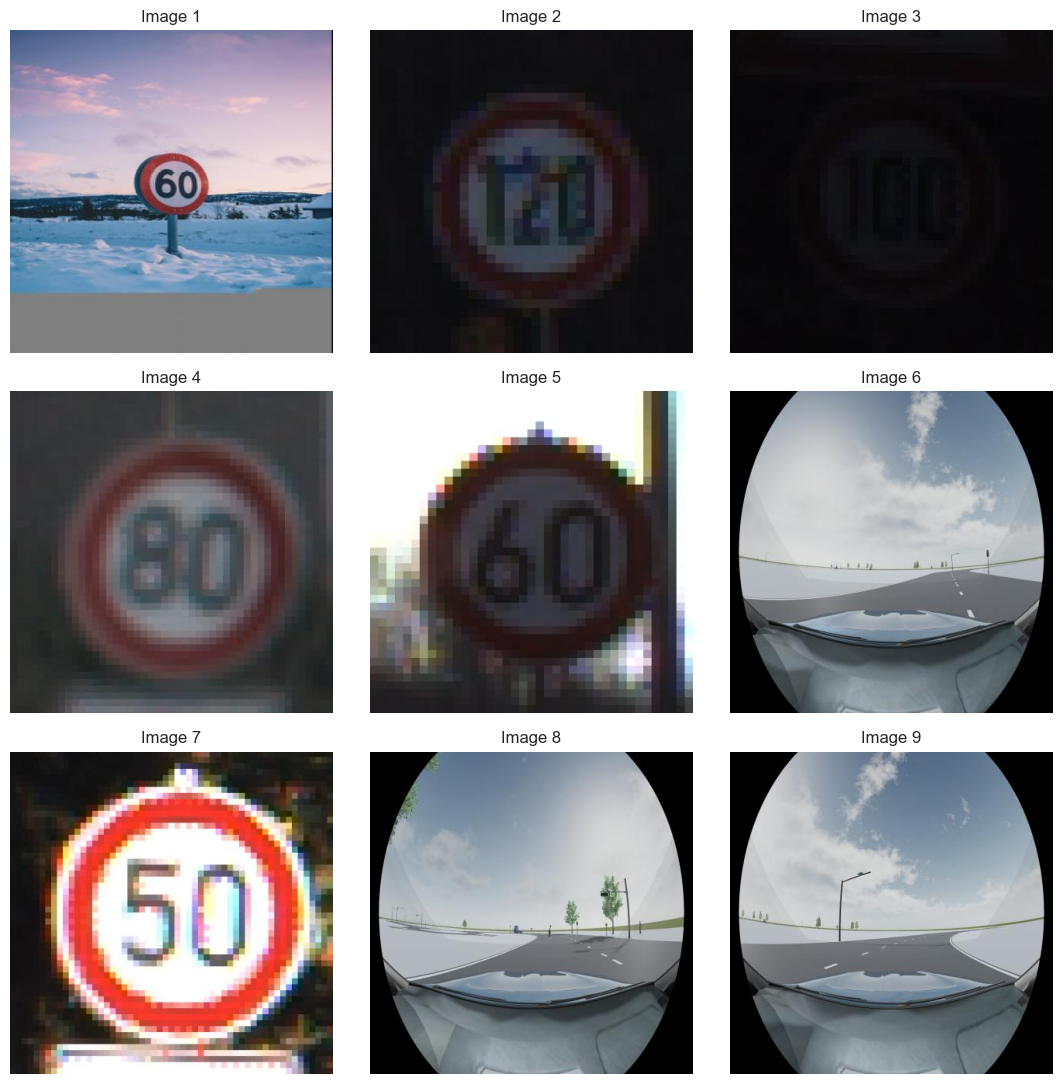

In [11]:
num_samples = 9

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Looking good! Now we have a pretty good idea of how the images are structured. Let's look at the image distribution before we can move on to training end evaluating our models 

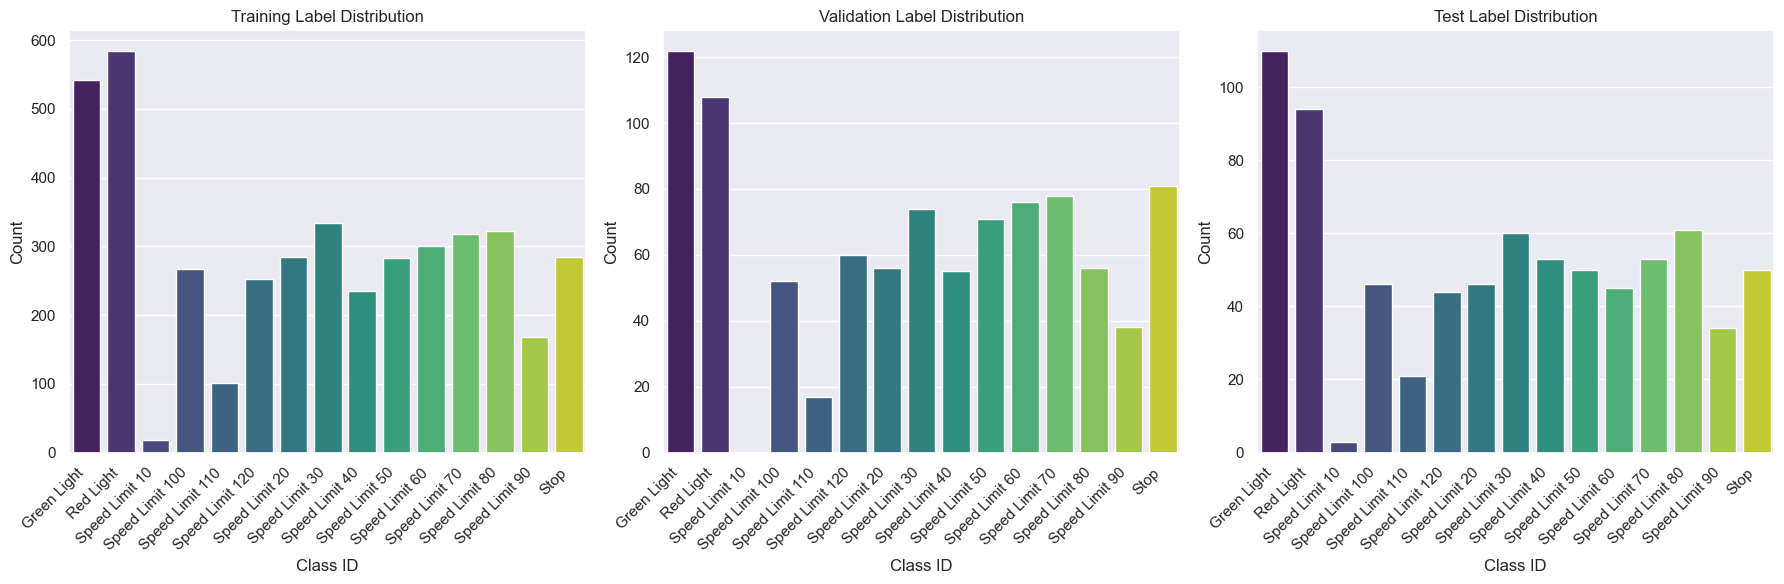

In [12]:
# train
train_label_counts = {label: 0 for label in class_names.values()} 
for label_file in train_labels:
    with open(os.path.join(path, 'data', 'train', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            train_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
train_label_counts_df = pd.DataFrame(list(train_label_counts.items()), columns=['Class ID', 'Count'])

# Validation
val_label_counts = {label: 0 for label in class_names.values()}
for label_file in val_labels:
    with open(os.path.join(path, 'data', 'valid', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            val_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
val_label_counts_df = pd.DataFrame(list(val_label_counts.items()), columns=['Class ID', 'Count'])   

# Test
test_label_counts = {label: 0 for label in class_names.values()}
for label_file in test_labels:
    with open(os.path.join(path, 'data', 'test', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            test_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
test_label_counts_df = pd.DataFrame(list(test_label_counts.items()), columns=['Class ID', 'Count'])


# Create three subplots for train, validation, and test label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, df, title in zip(axes,
                         [train_label_counts_df, val_label_counts_df, test_label_counts_df],
                         ['Training', 'Validation', 'Test']):
    sns.barplot(x='Class ID', y='Count', data=df, ax=ax, palette='viridis')
    ax.set_title(f'{title} Label Distribution')
    ax.set_xlabel('Class ID')
    ax.set_ylabel('Count')
    # rotate the labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

We can observe some very dispare class distribution, yet there is some sort of consistency across the different datasets (train, val, test). Below are a few considerations:
- Given the extreme class imbalance of Speed Limit 10, we decide to drop it. We will however keep Speed Limit 110 as it is a significantly imbalanced class which can perhaps help deliver a valuable Error Analysis later. 
- To tackle the class imbalance, we could **switch the classification head to Focal Loss**, which is a provided option for YOLOv8. 
- It is also interesting to allow for class-specific confidence thresholds at inference time, to further account for the class imbalance. 

# Part 2: Few-Shot Training <a id="part2"></a>

### 2.1 Few-Shot Dataset Creation

In [14]:
# !pip install --upgrade ultralytics ray

We create a function that has as parameters the percentage of data that we want to use and the distribution (label_counts_df) of our traning data. Additionally we have an skip_classes parameter that allows to drop any class we want, in this case we will drop class # 2 because if the extreme class imbalance

Let's create the dataset used for the few-show training of our YOLOv8 classification model. To do so, here are a few considerations to bear in mind in the design:
- We keep the same (approx.) distribution of labels as in the full train dataset, excluding the `Speed Limit 10` label. 
- When selecting the images, we use those that have only the specific class we are looking for (no multi-label images)

In [13]:
def create_few_shot_dataset(path, percentage, label_counts_df, skip_classes=None):
    Image_dir = os.path.join(path, 'data', 'train', 'images')
    label_dir = os.path.join(path, 'data', 'train', 'labels')
    train_labels = os.listdir(label_dir)

    # Create few-shot directories
    few_shot_data_dir = os.path.join(path, f'data/few_shot_{int(percentage*100)}pct')
    few_shot_img_dir = os.path.join(few_shot_data_dir, 'images')
    few_shot_lbl_dir = os.path.join(few_shot_data_dir, 'labels')
    os.makedirs(few_shot_img_dir, exist_ok=True)
    os.makedirs(few_shot_lbl_dir, exist_ok=True)

    # Convert label counts into a dict: {'0': 542, '1': 585, ...}
    label_counts_dict = {str(i): row['Count'] for i, row in label_counts_df.iterrows()}

    if skip_classes is None:
        skip_classes = []

    def copy_few_shot_images(class_id, num_images):
        matching = []
        for lf in train_labels:
            lbl_path = os.path.join(label_dir, lf)
            with open(lbl_path) as f:
                lines = [line.strip() for line in f if line.strip()]
                if lines and all(line.split()[0] == class_id for line in lines):
                    matching.append(lf)

        if len(matching) < num_images:
            print(f"Warning: not enough examples for class {class_id}, requested {num_images}, found {len(matching)}")
            num_images = len(matching)

        for lf in random.sample(matching, num_images):
            img_name = lf.replace('.txt', '.jpg')
            shutil.copy(os.path.join(Image_dir, img_name), os.path.join(few_shot_img_dir, img_name))
            shutil.copy(os.path.join(label_dir, lf), os.path.join(few_shot_lbl_dir, lf))

    # Process all classes
    for class_id, total_count in label_counts_dict.items():
        if class_id in skip_classes:
            continue
        few_shot_count = max(1, int(total_count * percentage))
        copy_few_shot_images(class_id, few_shot_count)

    print(f"Few-shot dataset created with {len(os.listdir(few_shot_img_dir))} images at {percentage*100}%")


In [16]:
train_label_counts_df = pd.DataFrame(train_label_counts_df)  # label counts dataframe
create_few_shot_dataset(path, 0.065, train_label_counts_df, skip_classes=['2'])

Few-shot dataset created with 271 images at 6.5%


Note that before training, we need to create a .yaml file. This a custom ultralytics YOLO dataset configuration in which we define the dataset root directory, relative paths to training and validation a a dictionary of class names

# 2.1 Model 1: Few-Shot 6.5%

As a baseline, we fine-tuned a pretrained YOLOv8 model on our 10-shot-per-class dataset using no augmentation and default loss. This will serve as a practical lower bound for few-shot object detection.

In [17]:
# Build from YAML and transfer weights
baseline_model = YOLO('yolov8n.pt')  

cfg_path = os.path.join(os.getcwd(), 'data', 'few_shot_data_6.yaml')

# Train the Model !!
result_baseline = baseline_model.train(
    data=cfg_path,
    epochs=10,
    batch=16,
    optimizer='auto',
    name='few_shot_training_6', 
    mosaic=0.0,      # no mosaic augmentation
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # no HSV color jitter
    fliplr=0.0,      # no horizontal flips
    flipud=0.0       # no vertical flips
)

New https://pypi.org/project/ultralytics/8.3.156 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_data_6.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=y

2025-06-18 19:13:20,385	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_6pct\labels... 271 images, 0 backgrounds, 0 corrupt: 100%|██████████| 271/271 [00:00<00:00, 344.71it/s]

train: New cache created: C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_6pct\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 28.96.7 MB/s, size: 21.4 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs\detect\few_shot_training_6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\few_shot_training_6
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.09G      1.333      5.313      1.636         15        640: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        801        944     0.0358     0.0771     0.0253     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.04G     0.9301       4.75      1.299         18        640: 100%|██████████| 17/17 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.53it/s]

                   all        801        944     0.0378      0.577     0.0707     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.05G     0.8893       4.24      1.206         16        640: 100%|██████████| 17/17 [00:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]

                   all        801        944     0.0187      0.772      0.102     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.05G     0.8653      4.037        1.2         16        640: 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.51it/s]

                   all        801        944     0.0137      0.805      0.142      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.05G     0.8268      3.844      1.151         18        640: 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        801        944      0.537      0.062      0.169      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.04G     0.8067      3.541      1.127         15        640: 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        801        944      0.415      0.141       0.21      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.05G     0.7856      3.442      1.074         16        640: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        801        944      0.306      0.304      0.255      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.05G     0.7462      3.281      1.055         17        640: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.42it/s]

                   all        801        944      0.285      0.399      0.284      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.05G      0.731      3.171      1.073         18        640: 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.42it/s]

                   all        801        944      0.351      0.387      0.329      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.06G     0.7196      2.968       1.02         16        640: 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        801        944      0.374      0.396      0.346      0.284



10 epochs completed in 0.034 hours.
Optimizer stripped from runs\detect\few_shot_training_6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\few_shot_training_6\weights\best.pt, 6.2MB

Validating runs\detect\few_shot_training_6\weights\best.pt...
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


                   all        801        944      0.372      0.397      0.346      0.285
           Green Light         87        122      0.461      0.322      0.291      0.156
             Red Light         74        108      0.487      0.361      0.366      0.193
       Speed Limit 100         52         52      0.176      0.288      0.182      0.164
       Speed Limit 110         17         17     0.0939      0.235      0.164      0.156
       Speed Limit 120         60         60      0.278      0.467      0.309      0.263
        Speed Limit 20         56         56      0.851      0.611      0.728      0.616
        Speed Limit 30         71         74       0.24      0.419      0.295      0.265
        Speed Limit 40         53         55      0.278      0.382      0.353      0.292
        Speed Limit 50         68         71      0.195     0.0423       0.11     0.0891
        Speed Limit 60         76         76      0.271      0.579      0.338       0.29
        Speed Limit 7

In [18]:
results_training_fewshot = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","few_shot_training_6","results.csv"))
results_training_fewshot.tail(10)

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   35.8801         1.33263         5.31252         1.63648   
1      2   45.8732         0.93007         4.75032         1.29899   
2      3   55.6491         0.88927         4.24015         1.20585   
3      4   65.2664         0.86527         4.03667         1.19988   
4      5   74.8262         0.82680         3.84376         1.15080   
5      6   84.3942         0.80671         3.54088         1.12651   
6      7   93.9883         0.78563         3.44220         1.07405   
7      8  103.6570         0.74618         3.28050         1.05528   
8      9  113.2850         0.73103         3.17095         1.07329   
9     10  122.9650         0.71963         2.96825         1.02049   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.03585            0.07707           0.02531   
1               0.03777            0.57740           0.07072   
2               0.01870            0.77188           0.10151   
3               0.01368            0.80477           0.14209   
4               0.53653            0.06200           0.16942   
5               0.41547            0.14066           0.21035   
6               0.30624            0.30391           0.25493   
7               0.28538            0.39935           0.28358   
8               0.35133            0.38665           0.32910   
9               0.37426            0.39628           0.34580   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.02381       1.12602       3.77333       1.70896  0.000084   
1              0.05178       0.80681       3.65792       1.19537  0.000156   
2              0.07357       0.87238       3.43051       1.26067  0.000211   
3              0.11462       0.81385       3.10596       1.20491  0.000248   
4              0.13857       0.81102       2.88305       1.13917  0.000267   
5              0.17310       0.80110       2.69946       1.14227  0.000266   
6              0.21069       0.79200       2.40536       1.12095  0.000214   
7              0.23525       0.77388       2.24453       1.09841  0.000161   
8              0.27199       0.76228       2.09143       1.09032  0.000109   
9              0.28444       0.75742       1.99701       1.09076  0.000057   

     lr/pg1    lr/pg2  
0  0.000084  0.000084  
1  0.000156  0.000156  
2  0.000211  0.000211  
3  0.000248  0.000248  
4  0.000267  0.000267  
5  0.000266  0.000266  
6  0.000214  0.000214  
7  0.000161  0.000161  
8  0.000109  0.000109  
9  0.000057  0.000057

In [ ]:
def plot_training_metrics(results_df, title='Training Metrics and Loss'):
    # Ensure column names are clean
    results_df.columns = results_df.columns.str.strip()
    
    # Define metrics to plot and their titles
    plot_config = [
        ('train/box_loss', 'Train Box Loss'),
        ('train/cls_loss', 'Train Class Loss'),
        ('train/dfl_loss', 'Train DFL Loss'),
        ('metrics/precision(B)', 'Metrics Precision (B)'),
        ('metrics/recall(B)', 'Metrics Recall (B)'),
        ('metrics/mAP50(B)', 'Metrics mAP50 (B)'),
        ('metrics/mAP50-95(B)', 'Metrics mAP50-95 (B)'),
        ('val/box_loss', 'Validation Box Loss'),
        ('val/cls_loss', 'Validation Class Loss'),
        ('val/dfl_loss', 'Validation DFL Loss'),
    ]

    # Create subplots
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

    # Flatten axes for easier iteration
    axs = axs.flatten()

    # Plot each metric
    for ax, (column, title_text) in zip(axs, plot_config):
        if column in results_df.columns:
            sns.lineplot(x='epoch', y=column, data=results_df, ax=ax)
            ax.set(title=title_text)
        else:
            ax.set(title=f'{title_text} (Not Found)')
            ax.axis('off')

    plt.suptitle(title, fontsize=24)
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.show()


plot_training_metrics(results_training_fewshot)


## Model Validation

In [20]:
metrics = baseline_model.val(
    data=cfg_path,
    imgsz=416,
    batch=16,
    save=True,                # save images with boxes
    plots=True,               # save PR-curves, confusion matrix, etc.
    name='few_shot_val_6', 
    exist_ok=True             # overwrite if it already exists
)


Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 129.639.4 MB/s, size: 16.0 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.79it/s]


                   all        801        944      0.294      0.359      0.263      0.217
           Green Light         87        122      0.447      0.189      0.195      0.108
             Red Light         74        108      0.381      0.324      0.271      0.136
       Speed Limit 100         52         52      0.164      0.365      0.144      0.126
       Speed Limit 110         17         17      0.155      0.294      0.116      0.107
       Speed Limit 120         60         60      0.181      0.367      0.164      0.143
        Speed Limit 20         56         56      0.411      0.607      0.489      0.396
        Speed Limit 30         71         74      0.218      0.237       0.24      0.213
        Speed Limit 40         53         55      0.181      0.218      0.166       0.14
        Speed Limit 50         68         71      0.112     0.0423      0.101     0.0835
        Speed Limit 60         76         76        0.2      0.632      0.223      0.197
        Speed Limit 7

In [ ]:

def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png'
]

# Path to the directory containing the images
post_training_files_path = os.path.join((os.getcwd()),"runs","detect","few_shot_val_6")

# Display the images
display_images(post_training_files_path, image_files)


## Loading the Best Performing Model

By default YOLO saves the best model weights in terms of mAP@0.5:0.95 and mAP@0.5

In [22]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","few_shot_training_6","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val',
                        name='few_shot_best_model_6')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 136.688.3 MB/s, size: 17.4 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:08<00:00,  6.37it/s]


                   all        801        944      0.372      0.397      0.346      0.285
           Green Light         87        122      0.462       0.32      0.289      0.155
             Red Light         74        108      0.487      0.361      0.364      0.192
       Speed Limit 100         52         52      0.176      0.288      0.184      0.165
       Speed Limit 110         17         17     0.0938      0.235      0.162      0.154
       Speed Limit 120         60         60      0.278      0.467      0.309      0.263
        Speed Limit 20         56         56       0.85      0.606      0.726      0.613
        Speed Limit 30         71         74       0.24      0.419      0.295      0.265
        Speed Limit 40         53         55      0.279      0.382      0.354      0.295
        Speed Limit 50         68         71      0.195     0.0423      0.111     0.0893
        Speed Limit 60         76         76      0.272      0.579      0.339       0.29
        Speed Limit 7

## Predictions on Test Images using best few shot model

In [ ]:
def visualize_model_predictions(model, dataset_root='data', split='test', max_images=9, image_size=(640, 640)):
    """
    Loads images from a split, runs model predictions, and plots the annotated results.
    
    Args:
        model: A YOLOv8 model (or compatible) with a `.predict()` method.
        dataset_root (str): Root path to the dataset folder.
        split (str): Subdirectory name for the dataset split (e.g., 'test', 'valid').
        max_images (int): Number of images to visualize (default 9).
        image_size (tuple): Size to resize images to (default 640x640).
    """
    def normalize_image(image):
        return image / 255.0

    def resize_image(image, size=(640, 640)):
        return cv2.resize(image, size)

    valid_images_path = os.path.join(os.getcwd(), dataset_root, split, 'images')
    image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

    if len(image_files) == 0:
        print(f"No .jpg images found in {valid_images_path}")
        return

    step_size = max(1, len(image_files) // max_images)
    selected_images = [image_files[i] for i in range(0, len(image_files), step_size)][:max_images]

    fig, axes = plt.subplots(3, 3, figsize=(20, 21))
    fig.suptitle(f'{split.capitalize()} Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            image = cv2.imread(image_path)

            if image is not None:
                resized = resize_image(image, image_size)
                normalized = normalize_image(resized)
                normalized_uint8 = (normalized * 255).astype(np.uint8)

                # Predict with the model
                results = model.predict(source=normalized_uint8, imgsz=image_size[0], conf=0.5)
                
                # Annotate and display
                annotated = results[0].plot(line_width=1)
                annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_rgb)
                ax.set_title(selected_images[i])
            else:
                print(f"⚠️ Could not load image: {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Displaying the predictions
visualize_model_predictions(Valid_model, dataset_root='data', split='test', max_images=9)

# 2.2 Model 2: Few shot 13%

In [24]:
# Creating the data set
train_label_counts_df = pd.DataFrame(train_label_counts_df)  # label counts dataframe
create_few_shot_dataset(path, 0.13, train_label_counts_df, skip_classes=['2'])

Few-shot dataset created with 550 images at 13.0%


In [25]:
# Train the Model !!
cfg_path = os.path.join(os.getcwd(), 'data', 'few_shot_data_13.yaml')

result_baseline = baseline_model.train(
    data=cfg_path,
    epochs=10,
    batch=16,
    optimizer='auto',
    name='few_shot_training_13', 
    mosaic=0.0,      # no mosaic augmentation
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # no HSV color jitter
    fliplr=0.0,      # no horizontal flips
    flipud=0.0       # no vertical flips
)

New https://pypi.org/project/ultralytics/8.3.156 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_data_13.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=

train: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_13pct\labels... 550 images, 0 backgrounds, 0 corrupt: 100%|██████████| 550/550 [00:01<00:00, 398.38it/s]

train: New cache created: C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_13pct\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 166.562.9 MB/s, size: 21.4 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs\detect\few_shot_training_13\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\few_shot_training_13
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.98G      2.016      4.982      1.958          6        640: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


                   all        801        944      0.232     0.0655     0.0483     0.0303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.98G      1.227      4.036      1.466          6        640: 100%|██████████| 35/35 [00:06<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        801        944      0.183      0.339      0.165      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.98G     0.9816      3.691        1.3          8        640: 100%|██████████| 35/35 [00:06<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


                   all        801        944      0.271      0.434      0.267       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.98G     0.9206      3.395      1.243          7        640: 100%|██████████| 35/35 [00:06<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        801        944      0.337      0.416      0.319      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.98G     0.8485      3.159      1.186          6        640: 100%|██████████| 35/35 [00:06<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


                   all        801        944      0.357      0.445      0.353      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.98G     0.8271      3.027      1.181          6        640: 100%|██████████| 35/35 [00:06<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        801        944      0.389      0.458      0.391      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.98G     0.7835      2.966       1.13          6        640: 100%|██████████| 35/35 [00:06<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        801        944      0.409      0.461      0.419      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.98G     0.7548        2.8      1.115          7        640: 100%|██████████| 35/35 [00:06<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        801        944      0.443      0.472      0.438      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.98G     0.7449      2.696      1.101          8        640: 100%|██████████| 35/35 [00:06<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.27it/s]

                   all        801        944      0.493      0.481      0.453      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.98G     0.7481      2.706        1.1          7        640: 100%|██████████| 35/35 [00:06<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


                   all        801        944      0.467      0.476      0.459      0.388

10 epochs completed in 0.044 hours.
Optimizer stripped from runs\detect\few_shot_training_13\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\few_shot_training_13\weights\best.pt, 6.2MB

Validating runs\detect\few_shot_training_13\weights\best.pt...
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  3.88it/s]


                   all        801        944      0.467      0.476      0.459      0.388
           Green Light         87        122      0.451      0.303      0.291      0.155
             Red Light         74        108       0.42      0.402      0.373      0.185
       Speed Limit 100         52         52      0.375      0.442      0.363       0.34
       Speed Limit 110         17         17      0.351      0.294      0.296      0.272
       Speed Limit 120         60         60      0.407      0.617      0.539      0.482
        Speed Limit 20         56         56        0.6      0.821       0.81      0.689
        Speed Limit 30         71         74      0.386      0.527      0.459      0.413
        Speed Limit 40         53         55      0.406       0.46      0.327      0.277
        Speed Limit 50         68         71      0.276      0.169      0.242      0.204
        Speed Limit 60         76         76      0.725      0.579      0.621      0.543
        Speed Limit 7

In [26]:
results_training_fewshot = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","few_shot_training_13","results.csv"))
results_training_fewshot.tail(10)

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   39.4608         2.01610         4.98153         1.95795   
1      2   52.5291         1.22724         4.03580         1.46637   
2      3   65.6533         0.98159         3.69064         1.30008   
3      4   78.5371         0.92058         3.39490         1.24287   
4      5   91.6311         0.84848         3.15853         1.18618   
5      6  105.1320         0.82715         3.02687         1.18125   
6      7  118.0620         0.78350         2.96554         1.12981   
7      8  131.1180         0.75481         2.79970         1.11469   
8      9  144.0770         0.74488         2.69610         1.10080   
9     10  156.9760         0.74813         2.70609         1.10041   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.23180            0.06550           0.04829   
1               0.18272            0.33943           0.16546   
2               0.27053            0.43449           0.26656   
3               0.33717            0.41594           0.31938   
4               0.35732            0.44479           0.35324   
5               0.38902            0.45765           0.39054   
6               0.40901            0.46118           0.41926   
7               0.44314            0.47201           0.43810   
8               0.49346            0.48056           0.45334   
9               0.46747            0.47604           0.45887   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.03025       2.57496       3.34245       2.54652  0.000170   
1              0.12935       1.18084       2.65787       1.57245  0.000311   
2              0.22039       0.92066       2.27443       1.27784  0.000418   
3              0.26461       0.85020       2.01388       1.18980  0.000370   
4              0.29665       0.82805       1.93308       1.17554  0.000318   
5              0.32478       0.80306       1.85322       1.15722  0.000266   
6              0.35385       0.78774       1.76915       1.13618  0.000214   
7              0.37198       0.78057       1.71446       1.13388  0.000161   
8              0.38500       0.77037       1.68956       1.11950  0.000109   
9              0.38781       0.76219       1.66653       1.11183  0.000057   

     lr/pg1    lr/pg2  
0  0.000170  0.000170  
1  0.000311  0.000311  
2  0.000418  0.000418  
3  0.000370  0.000370  
4  0.000318  0.000318  
5  0.000266  0.000266  
6  0.000214  0.000214  
7  0.000161  0.000161  
8  0.000109  0.000109  
9  0.000057  0.000057

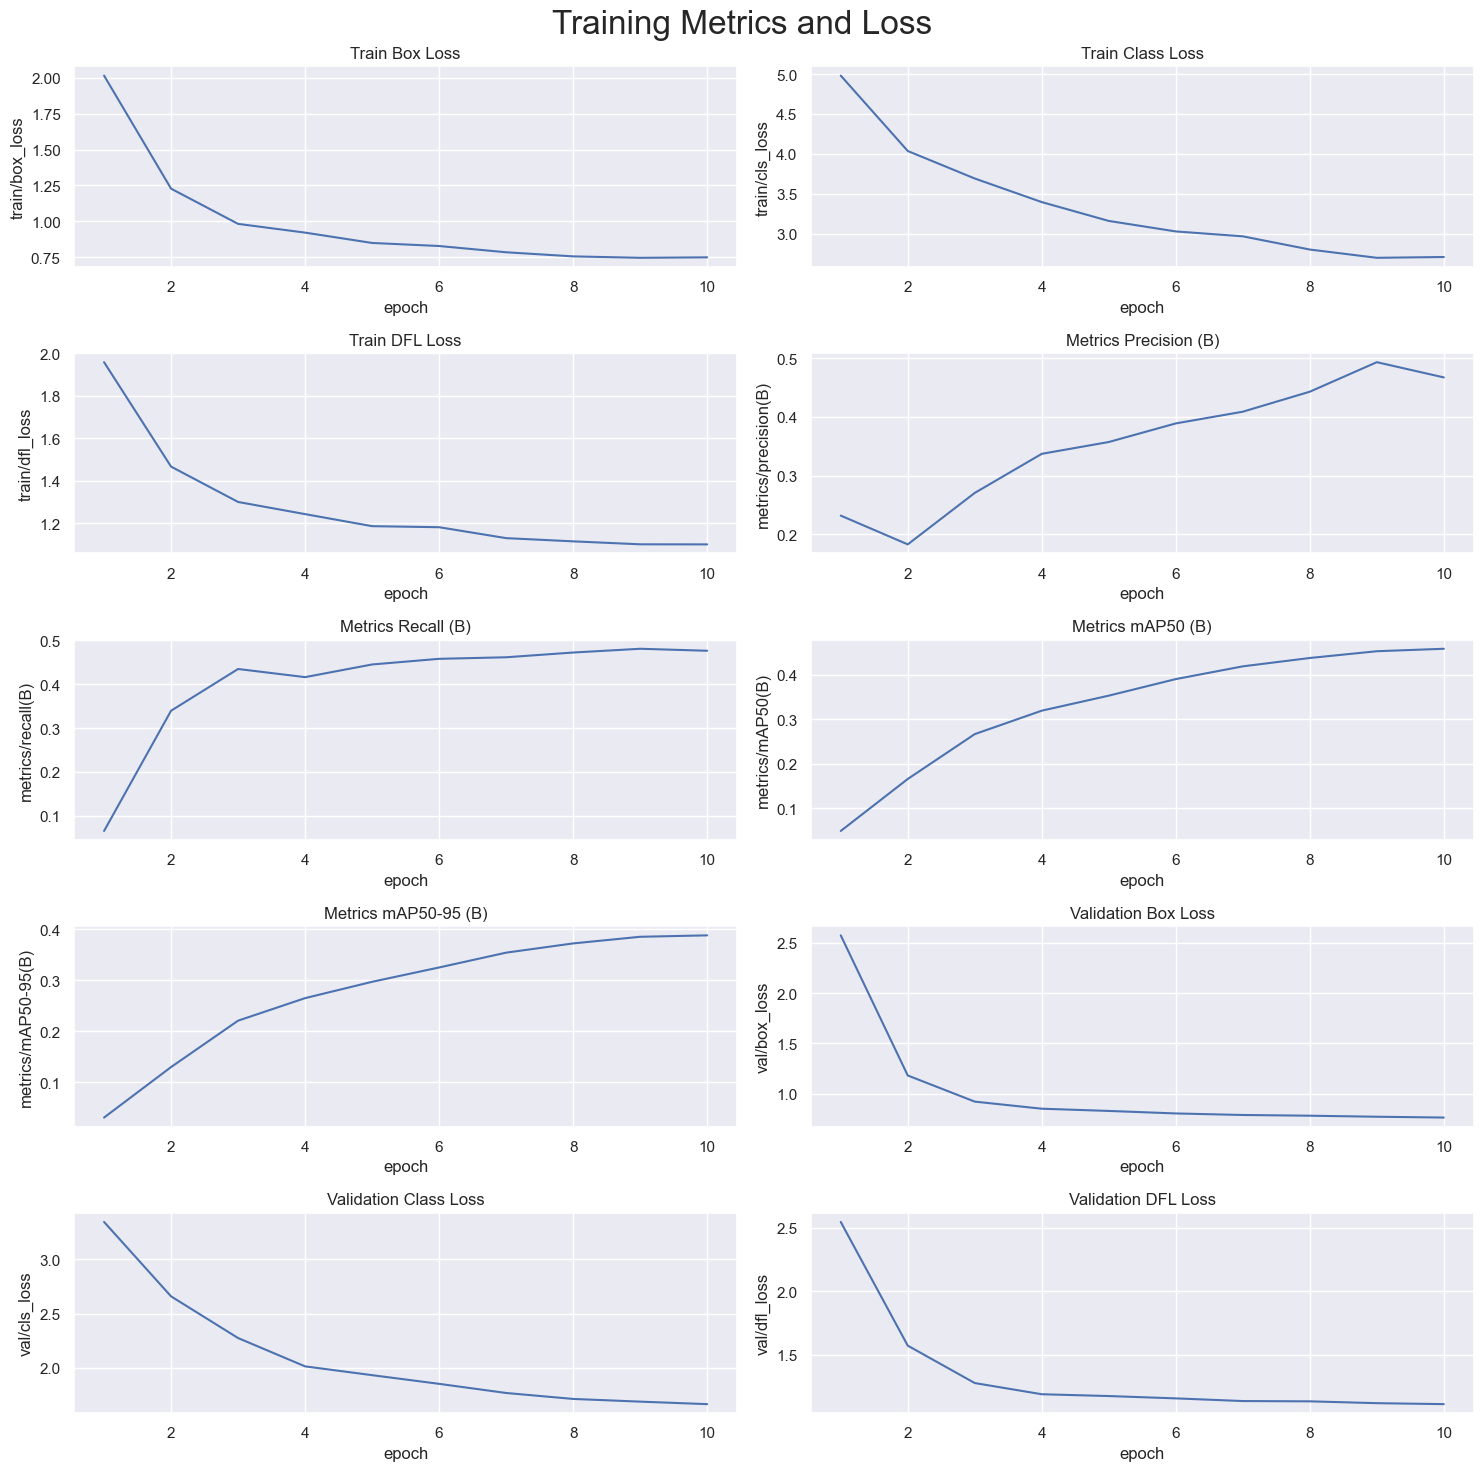

In [27]:
# Plotting training metrics
plot_training_metrics(results_training_fewshot)

In [28]:
# Validation
metrics = baseline_model.val(
    data=cfg_path,
    imgsz=416,
    batch=16,
    save=True,                # save images with boxes
    plots=True,               # save PR-curves, confusion matrix, etc.
    name='few_shot_val_13', 
    exist_ok=True             # overwrite if it already exists
)

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 79.732.2 MB/s, size: 16.0 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  9.10it/s]


                   all        801        944      0.418      0.405      0.376       0.32
           Green Light         87        122      0.534      0.188      0.206       0.11
             Red Light         74        108      0.406      0.278      0.223      0.114
       Speed Limit 100         52         52      0.318      0.304      0.301      0.266
       Speed Limit 110         17         17      0.477      0.353      0.378      0.344
       Speed Limit 120         60         60      0.364       0.55      0.433      0.385
        Speed Limit 20         56         56      0.601      0.714      0.692      0.598
        Speed Limit 30         71         74      0.321      0.541      0.387      0.343
        Speed Limit 40         53         55      0.166      0.173      0.182      0.146
        Speed Limit 50         68         71      0.447      0.182      0.277       0.23
        Speed Limit 60         76         76       0.43      0.553      0.475      0.423
        Speed Limit 7

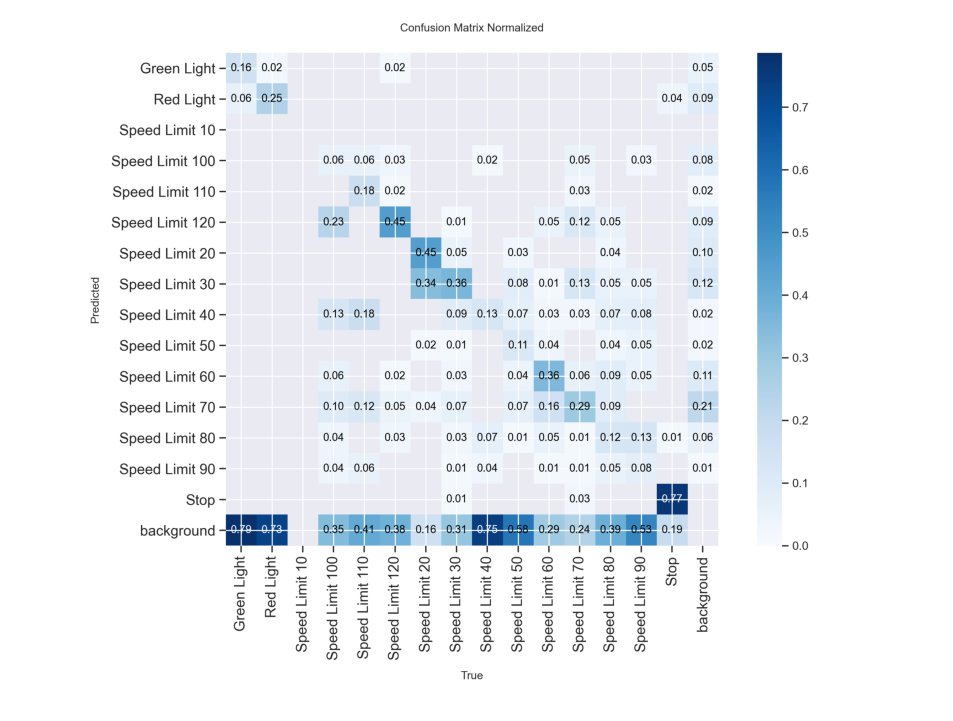

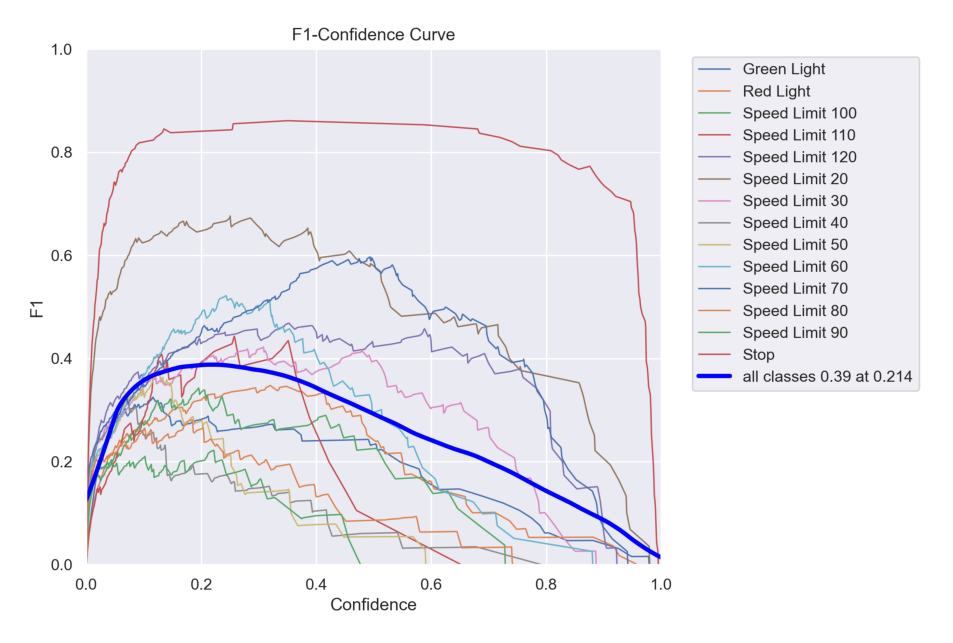

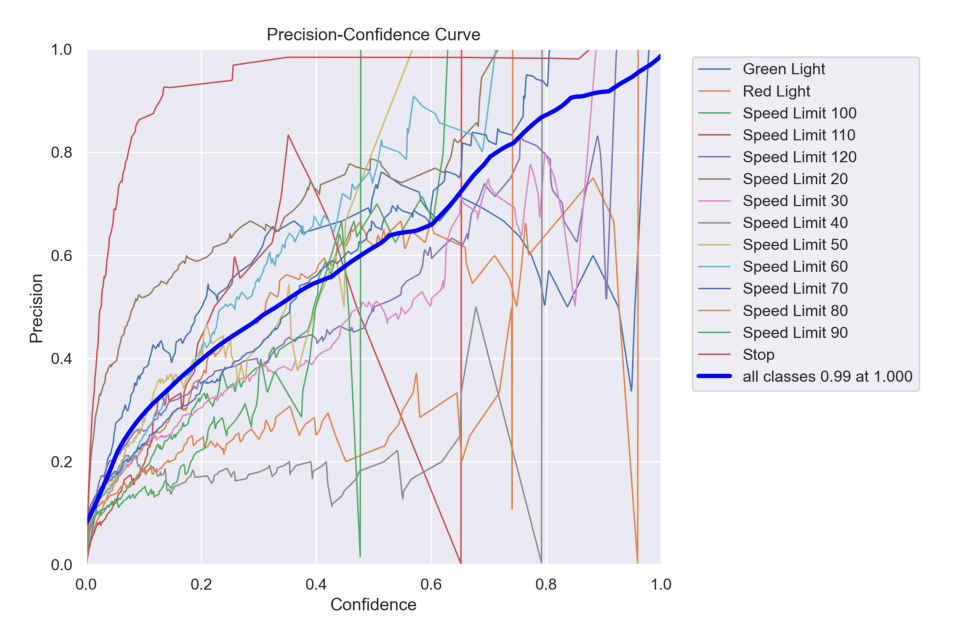

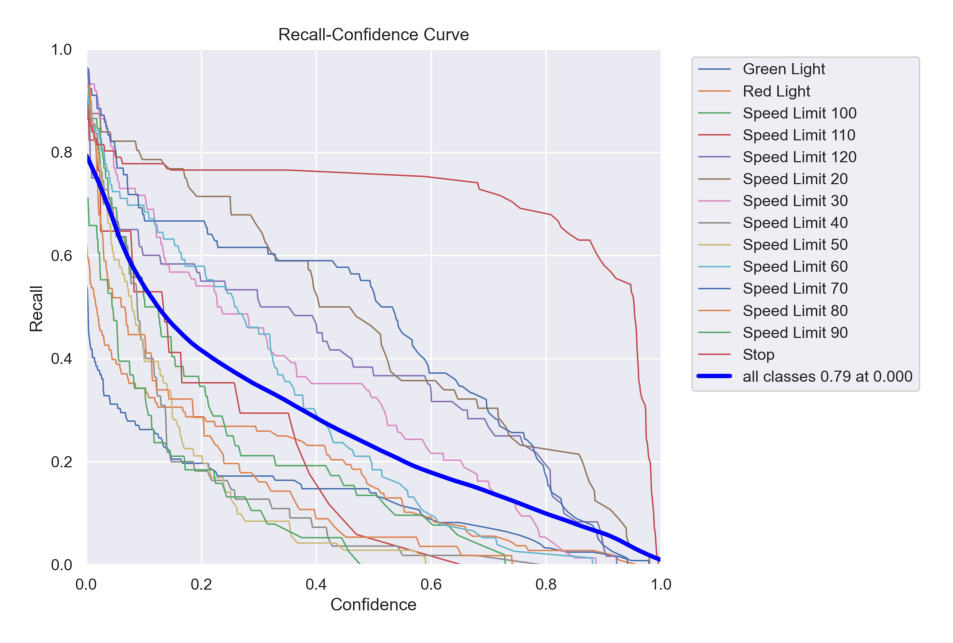

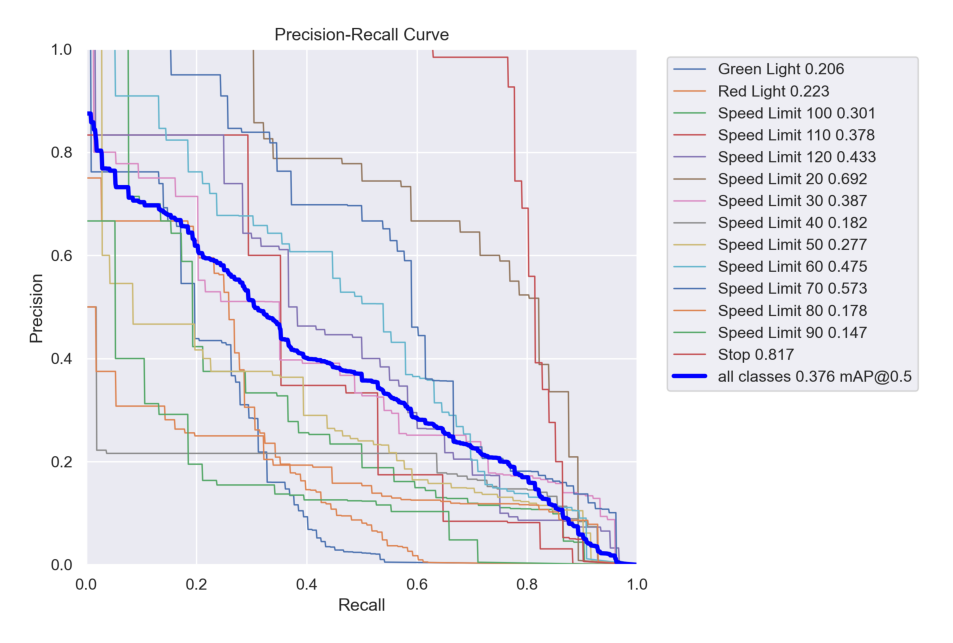

In [29]:
# Path to the directory containing the images
post_training_files_path = os.path.join((os.getcwd()),"runs","detect","few_shot_val_13")

# Display the images
display_images(post_training_files_path, image_files)

In [30]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","few_shot_training_13","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val',
                        name='few_shot_best_model_13')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 53.425.3 MB/s, size: 17.4 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:08<00:00,  6.15it/s]


                   all        801        944      0.467      0.476      0.459      0.388
           Green Light         87        122      0.448      0.303      0.293      0.154
             Red Light         74        108       0.42      0.402      0.373      0.187
       Speed Limit 100         52         52      0.375      0.442      0.363      0.341
       Speed Limit 110         17         17       0.35      0.294      0.296      0.272
       Speed Limit 120         60         60      0.408      0.617      0.539      0.483
        Speed Limit 20         56         56        0.6      0.821      0.809      0.687
        Speed Limit 30         71         74      0.386      0.527      0.458      0.413
        Speed Limit 40         53         55      0.406      0.461      0.329      0.277
        Speed Limit 50         68         71      0.276      0.169      0.247      0.207
        Speed Limit 60         76         76      0.725      0.579      0.621      0.542
        Speed Limit 7

In [ ]:
# Display a few predictions of the best model
visualize_model_predictions(Valid_model, dataset_root='data', split='test', max_images=9)


0: 640x640 1 Speed Limit 30, 20.6ms
Speed: 6.5ms preprocess, 20.6ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 20.7ms
Speed: 3.2ms preprocess, 20.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 70, 20.6ms
Speed: 2.8ms preprocess, 20.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Stop, 20.8ms
Speed: 3.7ms preprocess, 20.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.1ms
Speed: 3.0ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Green Light, 17.8ms
Speed: 3.1ms preprocess, 17.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Green Light, 19.6ms
Speed: 2.8ms preprocess, 19.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.9ms
Speed: 3.4ms preprocess, 18.9ms inference, 

# 2.3 Model 3: Few shot 25%

In [ ]:
# Creating the data set
train_label_counts_df = pd.DataFrame(train_label_counts_df)  # label counts dataframe
create_few_shot_dataset(path, 0.25, train_label_counts_df, skip_classes=['2'])

Few-shot dataset created with 1064 images at 25.0%


In [ ]:
# Train the Model !!
cfg_path = os.path.join(os.getcwd(), 'data', 'few_shot_data_25.yaml')

result_baseline = baseline_model.train(
    data=cfg_path,
    epochs=10,
    batch=16,
    optimizer='auto',
    name='few_shot_training_25', 
    mosaic=0.0,      # no mosaic augmentation
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # no HSV color jitter
    fliplr=0.0,      # no horizontal flips
    flipud=0.0       # no vertical flips
)

New https://pypi.org/project/ultralytics/8.3.156 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_data_25.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=

train: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_25pct\labels... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:03<00:00, 337.99it/s]


train: New cache created: C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_25pct\labels.cache
val: Fast image access  (ping: 0.20.1 ms, read: 94.349.7 MB/s, size: 21.4 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs\detect\few_shot_training_25\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\few_shot_training_25
Starting training for 10 epochs...
Closing dataloader mosaic


In [ ]:
results_training_fewshot = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","few_shot_training_25","results.csv"))
results_training_fewshot.tail(10)

In [ ]:
# Plotting training metrics
plot_training_metrics(results_training_fewshot)

In [ ]:
# Validation
metrics = baseline_model.val(
    data=cfg_path,
    imgsz=416,
    batch=16,
    save=True,                # save images with boxes
    plots=True,               # save PR-curves, confusion matrix, etc.
    name='few_shot_val_25', 
    exist_ok=True             # overwrite if it already exists
)

In [ ]:
# Path to the directory containing the images
post_training_files_path = os.path.join((os.getcwd()),"runs","detect","few_shot_val_25")

# Display the images
display_images(post_training_files_path, image_files)

In [ ]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","few_shot_training_25","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val',
                        name='few_shot_best_model_25')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

In [ ]:
# Display a few predictions of the best model
visualize_model_predictions(Valid_model, dataset_root='data', split='test', max_images=9)

# 2.4 Model 4: Few shot 50%

In [ ]:
# Creating the data set
train_label_counts_df = pd.DataFrame(train_label_counts_df)  # label counts dataframe
create_few_shot_dataset(path, 0.50, train_label_counts_df, skip_classes=['2'])

In [ ]:
# Train the Model !!
cfg_path = os.path.join(os.getcwd(), 'data', 'few_shot_data_50.yaml')

result_baseline = baseline_model.train(
    data=cfg_path,
    epochs=10,
    batch=16,
    optimizer='auto',
    name='few_shot_training_50', 
    mosaic=0.0,      # no mosaic augmentation
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # no HSV color jitter
    fliplr=0.0,      # no horizontal flips
    flipud=0.0       # no vertical flips
)

In [ ]:
results_training_fewshot = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","few_shot_training_50","results.csv"))
results_training_fewshot.tail(10)

In [ ]:
# Plotting training metrics
plot_training_metrics(results_training_fewshot)

In [ ]:
# Validation
metrics = baseline_model.val(
    data=cfg_path,
    imgsz=416,
    batch=16,
    save=True,                # save images with boxes
    plots=True,               # save PR-curves, confusion matrix, etc.
    name='few_shot_val_50', 
    exist_ok=True             # overwrite if it already exists
)

In [ ]:
# Path to the directory containing the images
post_training_files_path = os.path.join((os.getcwd()),"runs","detect","few_shot_val_50")

# Display the images
display_images(post_training_files_path, image_files)

In [ ]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","few_shot_training_50","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val',
                        name='few_shot_best_model_50')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

In [ ]:
# Display a few predictions of the best model
visualize_model_predictions(Valid_model, dataset_root='data', split='test', max_images=9)

# 2.5 Model 5: Full data set

In [22]:
# Build from YAML and transfer weights
baseline_model = YOLO('yolov8n.pt')  

# Train the Model !!
cfg_path = os.path.join(os.getcwd(), 'data', 'data.yaml')

result_baseline = baseline_model.train(
    data=cfg_path,
    epochs=10,
    batch=16,
    optimizer='auto',
    name='full_model_training', 
    mosaic=0.0,      # no mosaic augmentation
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # no HSV color jitter
    fliplr=0.0,      # no horizontal flips
    flipud=0.0,     # no vertical flips
    workers = 4
)

New https://pypi.org/project/ultralytics/8.3.156 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, 

train: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\train\labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.1 ms, read: 14.217.3 MB/s, size: 20.7 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs\detect\full_model_training\labels.jpg... 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FD2D992200>
Traceback (most recent call last):
  File "c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\full_model_training
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.07G     0.8599      4.025      1.201         15        640: 100%|██████████| 221/221 [00:46<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


                   all        801        944      0.315      0.475      0.412      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.06G     0.7612      2.753      1.074         14        640: 100%|██████████| 221/221 [00:42<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        801        944       0.65      0.592      0.651      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.06G     0.7122      2.008      1.045         12        640: 100%|██████████| 221/221 [00:42<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.48it/s]

                   all        801        944      0.783      0.707      0.778       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.06G     0.6784      1.522      1.016         12        640: 100%|██████████| 221/221 [00:41<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]

                   all        801        944      0.847      0.762      0.832       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.06G     0.6454      1.235     0.9941         12        640: 100%|██████████| 221/221 [00:41<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.57it/s]

                   all        801        944      0.926      0.781      0.886      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.04G     0.6103      1.016     0.9708         12        640: 100%|██████████| 221/221 [00:41<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.50it/s]

                   all        801        944      0.924      0.818      0.893      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.06G     0.5926     0.8845     0.9578         14        640: 100%|██████████| 221/221 [00:41<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.46it/s]

                   all        801        944      0.941      0.825      0.908      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.05G     0.5637     0.7905     0.9423         10        640: 100%|██████████| 221/221 [00:41<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.54it/s]

                   all        801        944      0.933      0.846      0.927      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.05G     0.5438     0.7217     0.9326         16        640: 100%|██████████| 221/221 [00:41<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.53it/s]

                   all        801        944      0.958      0.856      0.935      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.04G     0.5204     0.6697     0.9189         10        640: 100%|██████████| 221/221 [00:41<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.53it/s]

                   all        801        944      0.967      0.861      0.939      0.813



10 epochs completed in 0.138 hours.
Optimizer stripped from runs\detect\full_model_training\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\full_model_training\weights\best.pt, 6.2MB

Validating runs\detect\full_model_training\weights\best.pt...
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


                   all        801        944      0.967       0.86      0.939      0.813
           Green Light         87        122      0.883      0.682      0.812      0.469
             Red Light         74        108      0.897      0.704      0.814      0.497
       Speed Limit 100         52         52      0.961      0.941      0.962      0.881
       Speed Limit 110         17         17          1      0.876      0.959      0.882
       Speed Limit 120         60         60      0.998      0.883      0.976      0.897
        Speed Limit 20         56         56          1       0.94      0.984      0.852
        Speed Limit 30         71         74       0.96      0.959      0.975      0.926
        Speed Limit 40         53         55      0.997      0.909      0.973      0.875
        Speed Limit 50         68         71      0.943      0.803      0.957      0.854
        Speed Limit 60         76         76      0.985      0.878      0.957      0.865
        Speed Limit 7

In [23]:
results_training = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","full_model_training","results.csv"))
results_training.tail(10)

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   65.0598         0.85988         4.02483         1.20083   
1      2  114.4190         0.76123         2.75283         1.07432   
2      3  163.0460         0.71220         2.00820         1.04522   
3      4  210.5690         0.67842         1.52186         1.01647   
4      5  257.8470         0.64545         1.23463         0.99413   
5      6  305.4250         0.61029         1.01649         0.97080   
6      7  353.1040         0.59264         0.88447         0.95780   
7      8  400.7860         0.56369         0.79049         0.94234   
8      9  448.1890         0.54378         0.72167         0.93264   
9     10  496.0400         0.52038         0.66967         0.91894   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.31452            0.47461           0.41193   
1               0.64996            0.59229           0.65137   
2               0.78262            0.70682           0.77761   
3               0.84709            0.76223           0.83227   
4               0.92615            0.78139           0.88632   
5               0.92356            0.81795           0.89269   
6               0.94070            0.82527           0.90827   
7               0.93300            0.84598           0.92725   
8               0.95798            0.85642           0.93452   
9               0.96659            0.86071           0.93903   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.33717       0.77468       1.95652       1.12262  0.000175   
1              0.53460       0.76523       1.29967       1.07952  0.000315   
2              0.65012       0.72491       0.99658       1.05326  0.000421   
3              0.71030       0.66593       0.84087       1.01177  0.000370   
4              0.75274       0.66852       0.68098       1.00161  0.000318   
5              0.75691       0.64806       0.64293       0.98943  0.000266   
6              0.77538       0.61376       0.58284       0.97075  0.000214   
7              0.79284       0.61025       0.54735       0.96941  0.000161   
8              0.80387       0.60184       0.50467       0.96439  0.000109   
9              0.81303       0.57984       0.48115       0.95207  0.000057   

     lr/pg1    lr/pg2  
0  0.000175  0.000175  
1  0.000315  0.000315  
2  0.000421  0.000421  
3  0.000370  0.000370  
4  0.000318  0.000318  
5  0.000266  0.000266  
6  0.000214  0.000214  
7  0.000161  0.000161  
8  0.000109  0.000109  
9  0.000057  0.000057

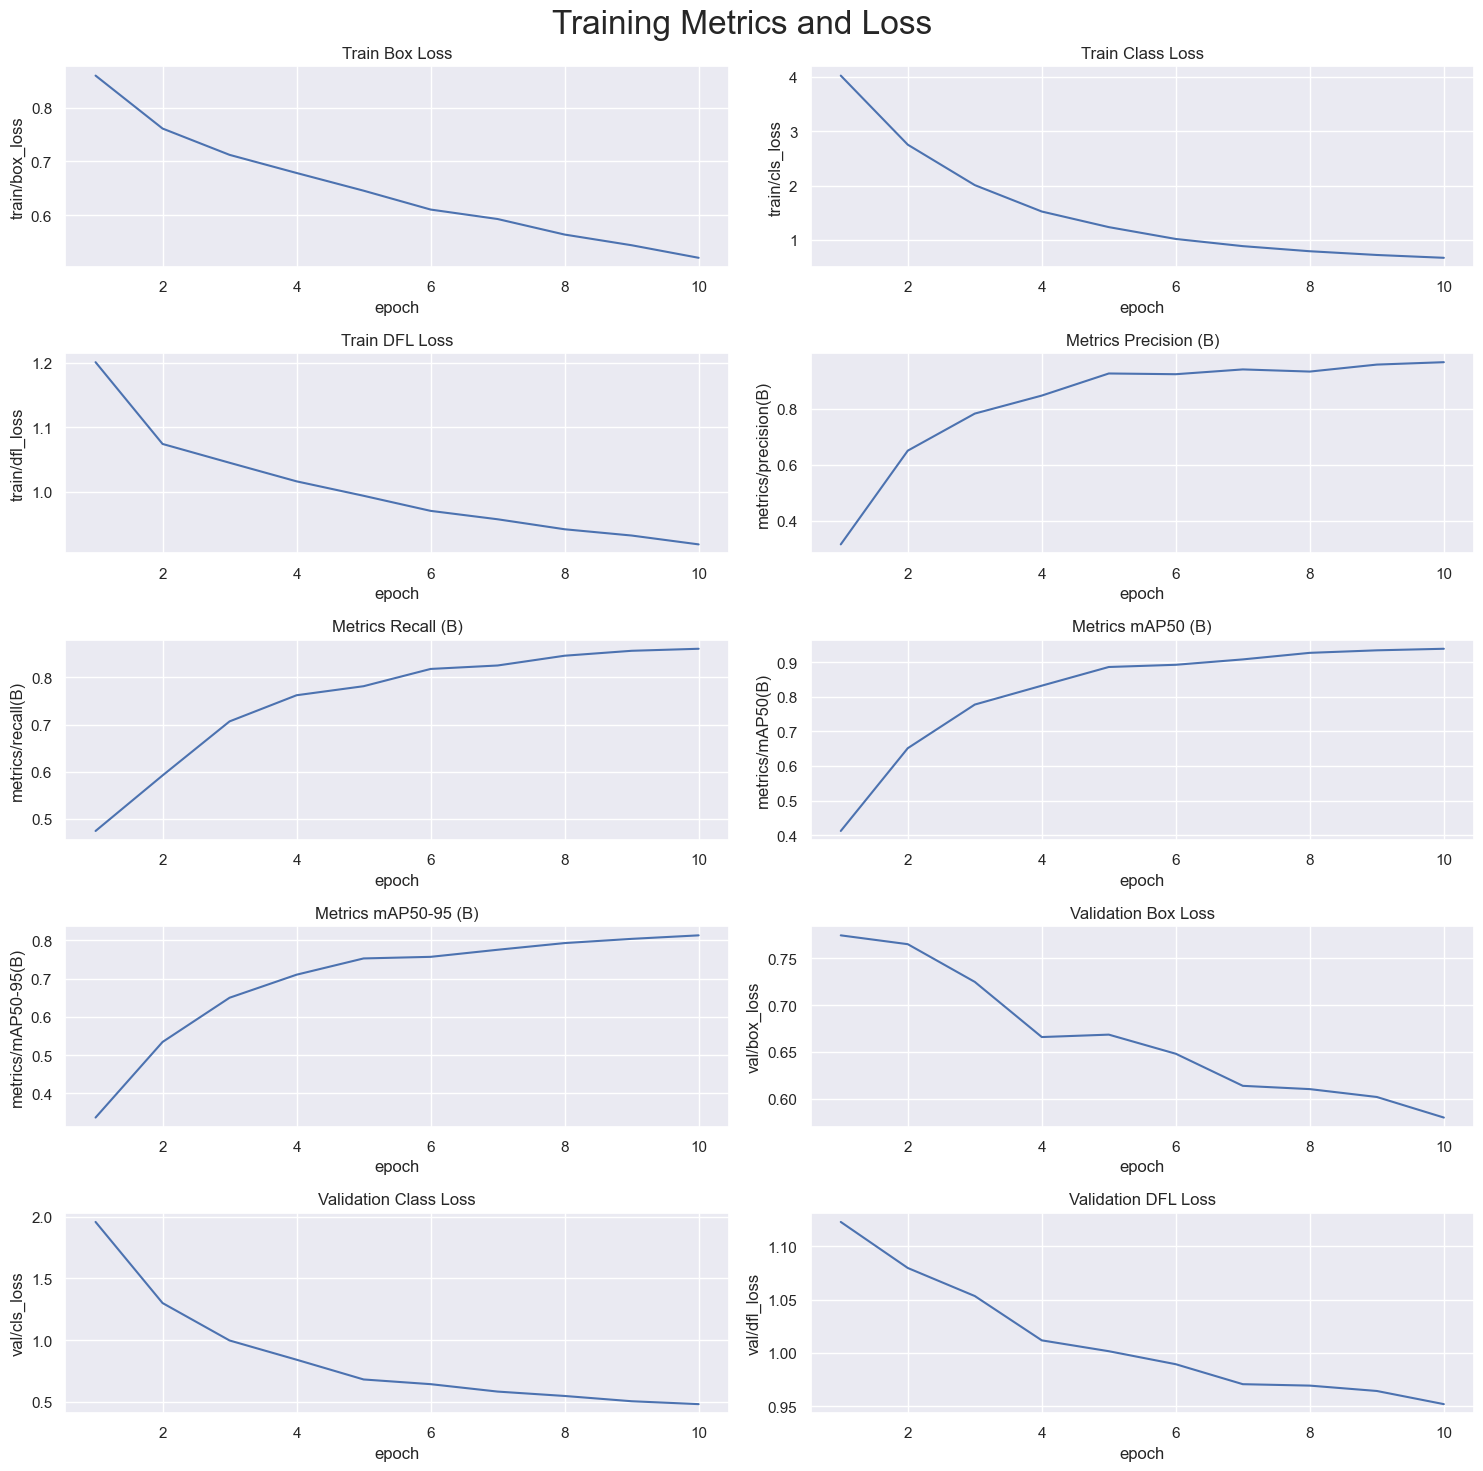

In [24]:
# Plotting training metrics
plot_training_metrics(results_training)

In [25]:
# Validation
metrics = baseline_model.val(
    data=cfg_path,
    imgsz=416,
    batch=16,
    save=True,                # save images with boxes
    plots=True,               # save PR-curves, confusion matrix, etc.
    name='full_model_validation', 
    exist_ok=True             # overwrite if it already exists
)

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 119.060.1 MB/s, size: 19.7 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  9.59it/s]


                   all        801        944      0.956      0.802      0.887      0.771
           Green Light         87        122      0.899      0.509      0.658      0.391
             Red Light         74        108      0.916      0.506      0.705       0.41
       Speed Limit 100         52         52      0.923      0.904      0.925      0.846
       Speed Limit 110         17         17      0.934      0.765       0.88       0.83
       Speed Limit 120         60         60       0.91      0.867       0.95      0.875
        Speed Limit 20         56         56          1      0.932      0.967      0.841
        Speed Limit 30         71         74      0.946      0.943      0.971      0.902
        Speed Limit 40         53         55      0.971      0.855      0.938      0.812
        Speed Limit 50         68         71       0.94      0.789      0.911      0.817
        Speed Limit 60         76         76      0.985      0.868      0.921      0.849
        Speed Limit 7

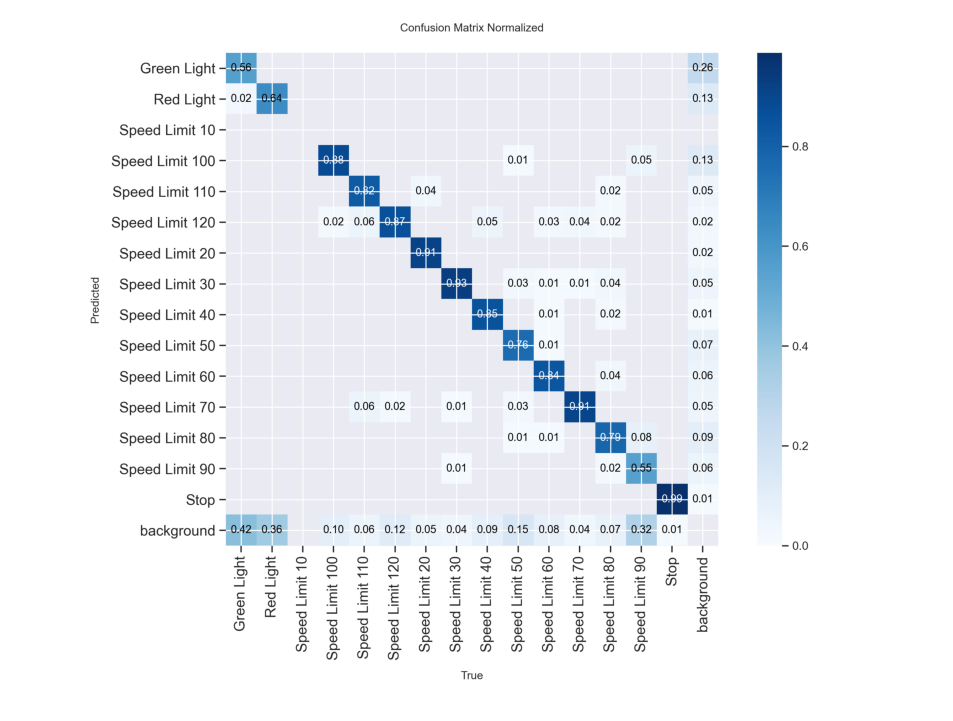

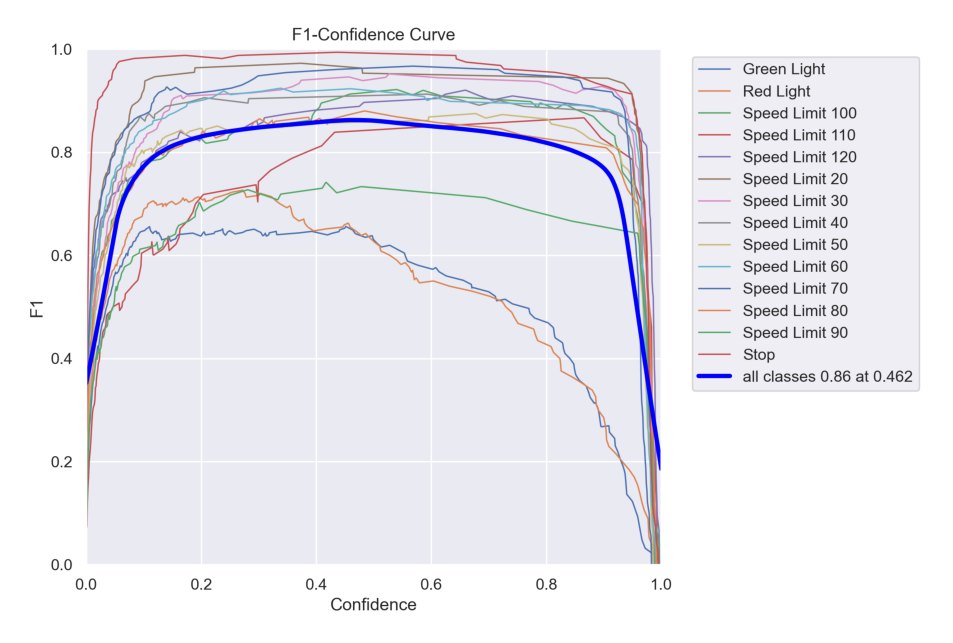

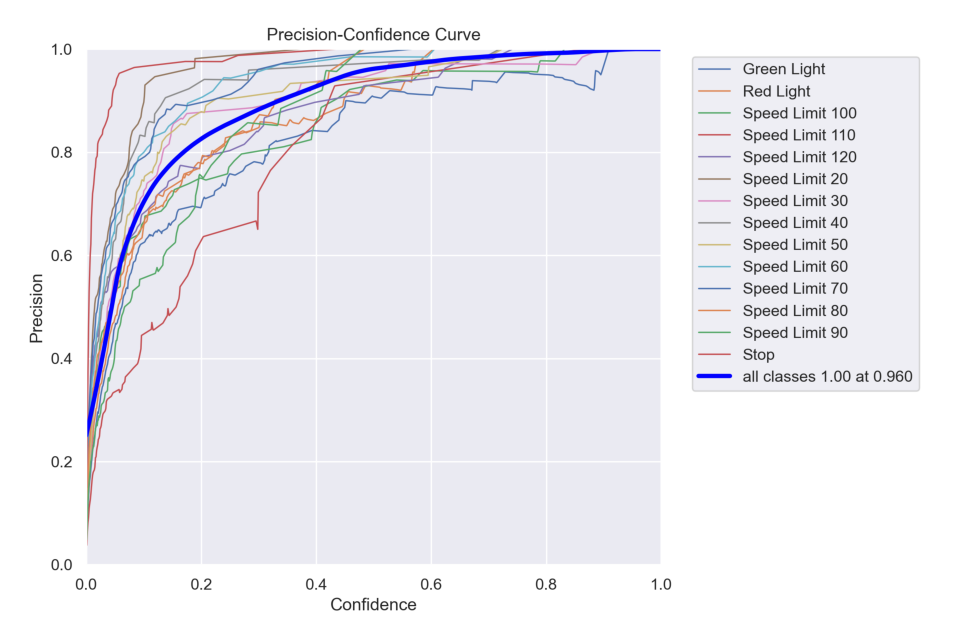

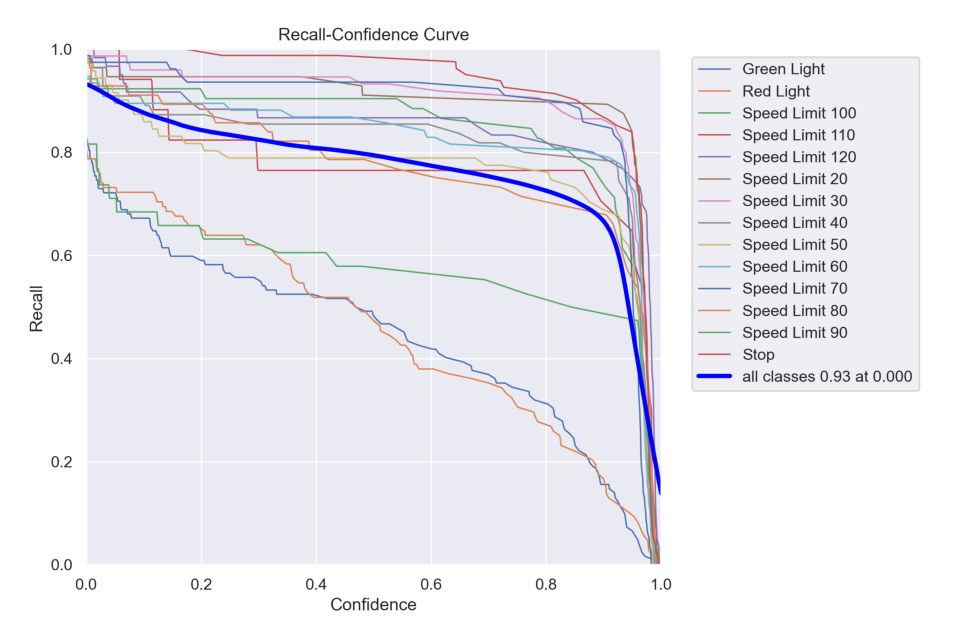

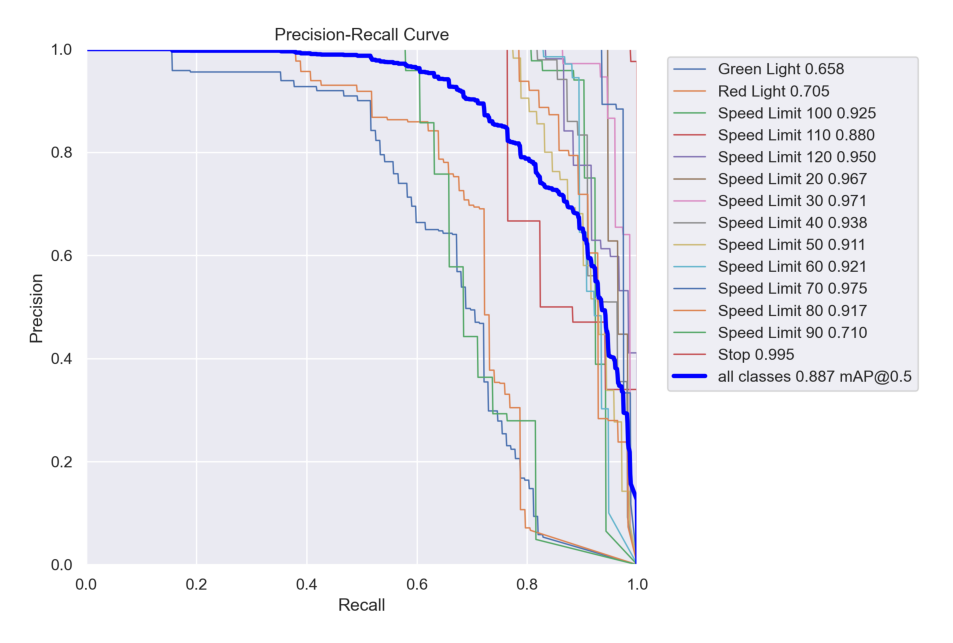

In [26]:
# Path to the directory containing the images
post_training_files_path = os.path.join((os.getcwd()),"runs","detect","full_model_validation")

# Display the images
display_images(post_training_files_path, image_files)

In [27]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","full_model_training","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val',
                        name='full_model_best')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 103.447.6 MB/s, size: 11.9 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:07<00:00,  6.71it/s]


                   all        801        944      0.964      0.862       0.94      0.814
           Green Light         87        122      0.884      0.688      0.812      0.468
             Red Light         74        108      0.873      0.704      0.822      0.505
       Speed Limit 100         52         52      0.958      0.942      0.962      0.881
       Speed Limit 110         17         17      0.998      0.882      0.959      0.887
       Speed Limit 120         60         60      0.992      0.883      0.976      0.895
        Speed Limit 20         56         56          1      0.943      0.984      0.855
        Speed Limit 30         71         74      0.958      0.959      0.975      0.926
        Speed Limit 40         53         55      0.994      0.909      0.973      0.875
        Speed Limit 50         68         71      0.941      0.803      0.957      0.855
        Speed Limit 60         76         76      0.985      0.879      0.957      0.866
        Speed Limit 7


0: 640x640 1 Speed Limit 30, 10.0ms
Speed: 3.3ms preprocess, 10.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 10.8ms
Speed: 3.7ms preprocess, 10.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 70, 10.7ms
Speed: 3.4ms preprocess, 10.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Stop, 10.5ms
Speed: 2.7ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Speed Limit 70s, 10.3ms
Speed: 3.4ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Green Lights, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Red Light, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Green Light, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 2

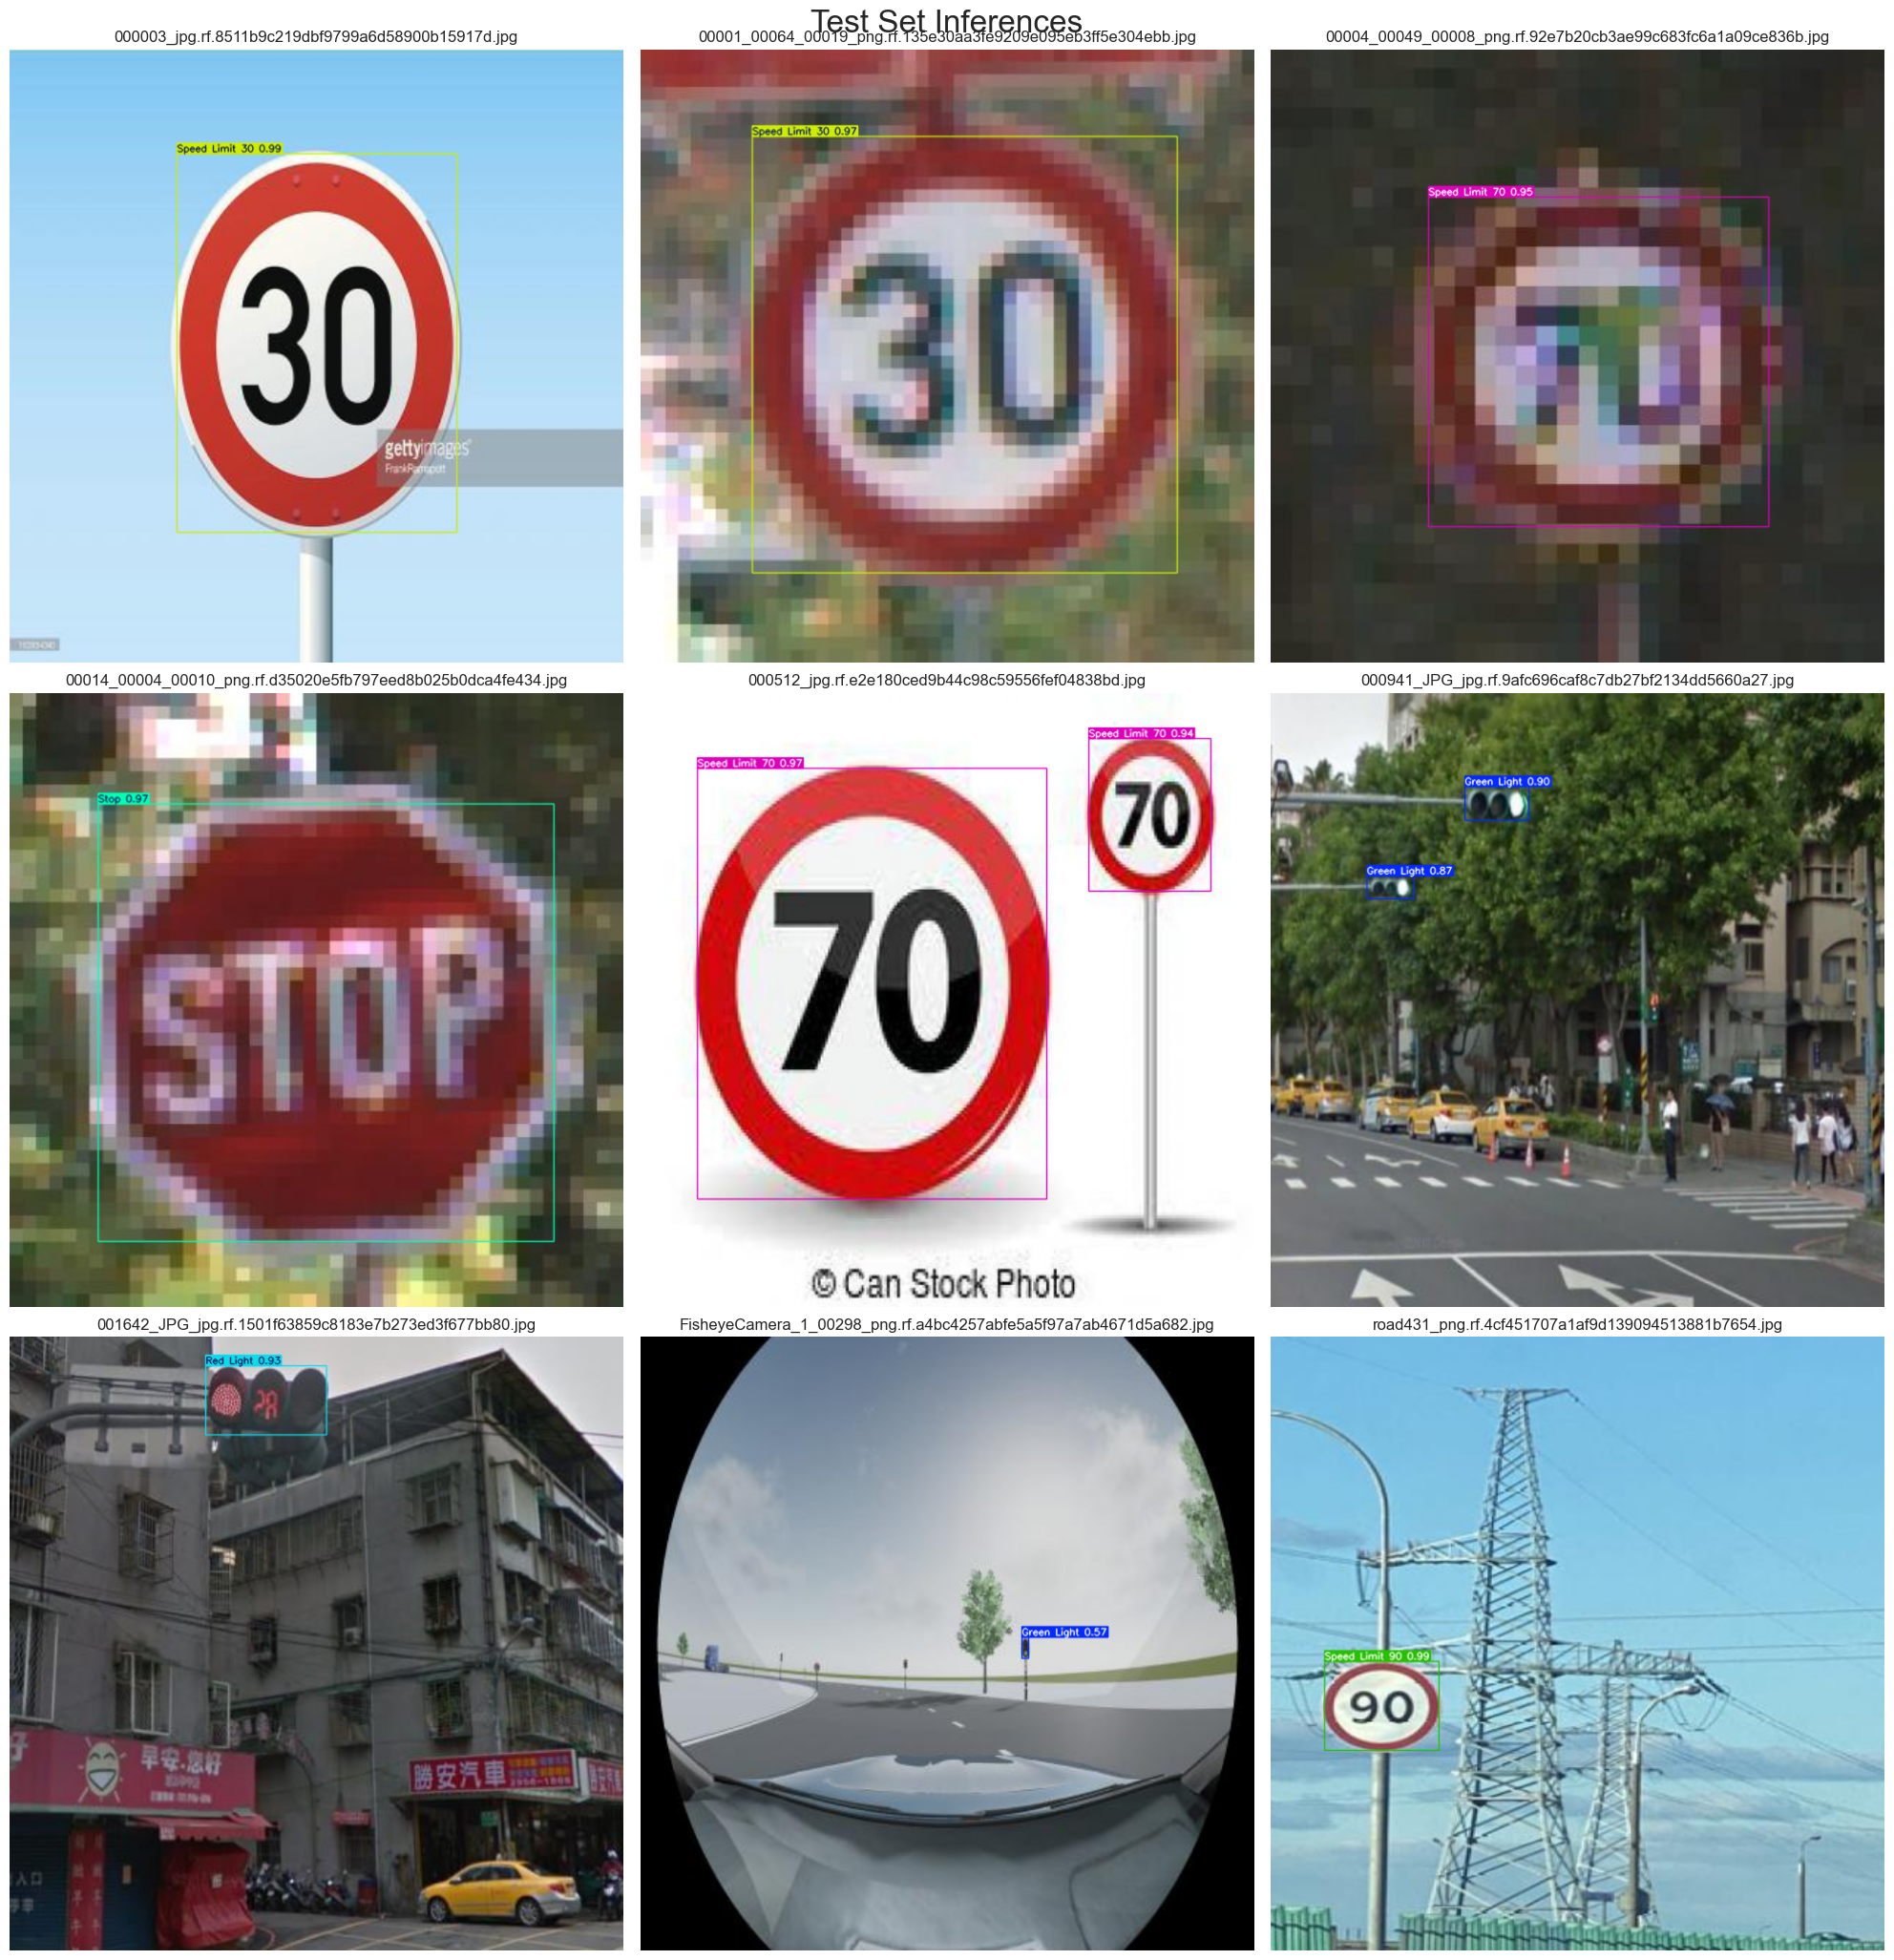

In [28]:
# Display a few predictions of the best model
visualize_model_predictions(Valid_model, dataset_root='data', split='test', max_images=9)